In [41]:
import pandas as pd
import pytz
import datetime as dt
import math
import seaborn as sns
import matplotlib as mpl
#mpl.rcParams['path.simplify'] = False
import matplotlib.pyplot as plt
import numpy as np
import os


In [114]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

## Psychopy Related Functions

In [42]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals

## Shimmer Related Functions

In [97]:
def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp


def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df
    







In [44]:
psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Psychopy_data/VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv"

In [45]:
psychopy_df = read_manipulate_psychopy(psychopy_file_path)
baseline_timestamp=get_nonNan_list_psychopy(psychopy_df,"baseline_instruction_ts")
start_timestamp = baseline_timestamp[0]

## offset time in min
time_offset = 5
stop_timestamp = get_offset_timestamp(start_timestamp, time_offset)

In [46]:
print(start_timestamp)
print(stop_timestamp)

1699449492.5466542
1699449792.546654


In [47]:
time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)
    
start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
end_time  = dt.datetime.fromtimestamp(stop_timestamp, tz)

print(start_time)
print(end_time)

2023-11-08 14:18:12.546654+01:00
2023-11-08 14:23:12.546654+01:00


In [48]:
ecg_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Shimmer_data/2023-11-08_13.52.04_VP005_081123_SD_Session1/VP005_081123_Session1_Shimmer_6B1E_Calibrated_SD.csv"

In [49]:
ecg_df = read_shimmer_sensor(ecg_file_path)

In [123]:
ecg_df

,Shimmer_6B1E_Timestamp_Unix_CAL,Shimmer_6B1E_Accel_LN_X_CAL,Shimmer_6B1E_Accel_LN_Y_CAL,Shimmer_6B1E_Accel_LN_Z_CAL,Shimmer_6B1E_ECG_EMG_Status1_CAL,Shimmer_6B1E_ECG_EMG_Status2_CAL,Shimmer_6B1E_ECG_IBI_LA_RA_CAL,Shimmer_6B1E_ECG_IBI_LL_LA_CAL,Shimmer_6B1E_ECG_IBI_LL_RA_CAL,Shimmer_6B1E_ECG_IBI_Vx_RL_CAL,Shimmer_6B1E_ECG_LA-RA_24BIT_CAL,Shimmer_6B1E_ECG_LL-LA_24BIT_CAL,Shimmer_6B1E_ECG_LL-RA_24BIT_CAL,Shimmer_6B1E_ECG_Vx-RL_24BIT_CAL,Shimmer_6B1E_ECGtoHR_LA_RA_CAL,Shimmer_6B1E_ECGtoHR_LL_LA_CAL,Shimmer_6B1E_ECGtoHR_LL_RA_CAL,Shimmer_6B1E_ECGtoHR_Vx_RL_CAL,NaN
0,1.6994493229086304E12,-5.8478260869565215,5.8478260869565215,0.8695652173913043,128.0,128.0,-1.0,-1.0,-1.0,-1.0,77.61571021267298,66.21890619026496,143.83461640293794,-95.24367871805177,-1.0,-1.0,-1.0,-1.0,NaN
1,1.6994493229164429E12,-5.858695652173913,5.858695652173913,0.8695652173913043,128.0,128.0,-1.0,-1.0,-1.0,-1.0,77.62732179490588,66.18832661966404,143.81564841456992,-95.22947075718294,-1.0,-1.0,-1.0,-1.0,NaN
2,1.699449322920349E12,-5.880434782608695,5.8478260869565215,0.8478260869565217,128.0,128.0,-1.0,-1.0,-1.0,-1.0,77.62212903763402,66.18573024102811,143.80785927866214,-95.25687697611774,-1.0,-1.0,-1.0,-1.0,NaN
3,1.6994493229242554E12,-5.891304347826087,5.858695652173913,0.858695652173913,128.0,128.0,-1.0,-1.0,-1.0,-1.0,77.63042302494324,66.18320598402096,143.8136290089642,-95.27195039653188,-1.0,-1.0,-1.0,-1.0,NaN
4,1.6994493229281616E12,-5.913043478260869,5.83695652173913,0.8152173913043478,128.0,128.0,-1.0,-1.0,-1.0,-1.0,77.6421788504337,66.17202713156071,143.8142059819944,-95.28312924899213,-1.0,-1.0,-1.0,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025464,1.699453332889099E12,5.695652173913043,2.1956521739130435,-6.043478260869565,128.0,128.0,-1.0,-1.0,-1.0,-1.0,77.94090663682302,93.65382953331824,171.59473617014126,-130.26861015184048,77.57575757575758,77.57575757575758,77.57575757575758,77.57575757575758,NaN
1025465,1.6994533328930054E12,5.673913043478261,2.1847826086956523,-6.076086956521739,128.0,128.0,-1.0,-1.0,-1.0,-1.0,77.93210779811237,93.67258115679995,171.60468895491232,-130.29543939774507,77.57575757575758,77.57575757575758,77.57575757575758,77.57575757575758,NaN
1025466,1.6994533328969116E12,5.641304347826087,2.217391304347826,-6.076086956521739,128.0,128.0,-1.0,-1.0,-1.0,-1.0,77.94739758341284,93.66839810233095,171.6157956857438,-130.27935627452806,77.57575757575758,77.57575757575758,77.57575757575758,77.57575757575758,NaN
1025467,1.6994533329008179E12,5.630434782608695,2.1847826086956523,-6.08695652173913,128.0,128.0,-1.0,-1.0,-1.0,-1.0,77.95980250356227,93.66371019646051,171.6235127000228,-130.3146958726282,77.57575757575758,77.57575757575758,77.57575757575758,77.57575757575758,NaN


In [124]:
ecg_col_name = "Shimmer_6B1E_ECG_LA-RA_24BIT_CAL"
timestamp_shimmer_col_name = "Shimmer_6B1E_Timestamp_Unix_CAL"

In [125]:
selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df=standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)

In [126]:
sliced_ecg_df=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp, stop_timestamp, timestamp_shimmer_col_name)
sliced_ecg_df=sliced_ecg_df.reset_index(drop=True)

In [137]:
sliced_ecg_df['heartrate'] = sliced_ecg_df[ecg_col_name]

In [138]:
sliced_ecg_df=col_from_str_float (sliced_ecg_df, ecg_col_name)

In [139]:
sampling_frequency = 256

In [140]:
plt.figure(figsize=(20, 7))

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

In [148]:
start = 0
stop = 2560
duration = (stop-start) / sampling_frequency


Text(0.5, 1.0, 'ECG signal, slice of 10.0 seconds')

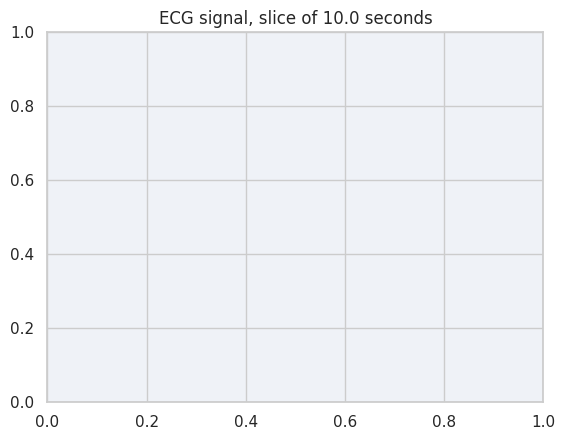

In [149]:
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})
plt.title("ECG signal, slice of %.1f seconds" % duration)

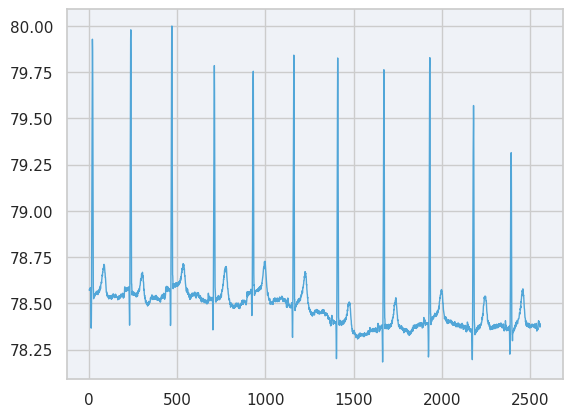

In [150]:
plt.plot(sliced_ecg_df[start:stop].index, sliced_ecg_df[start:stop].heartrate, color="#51A6D8", linewidth=1)

In [161]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity




def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [176]:
sampfrom = 60000
sampto = 70000
nr_plots = 1

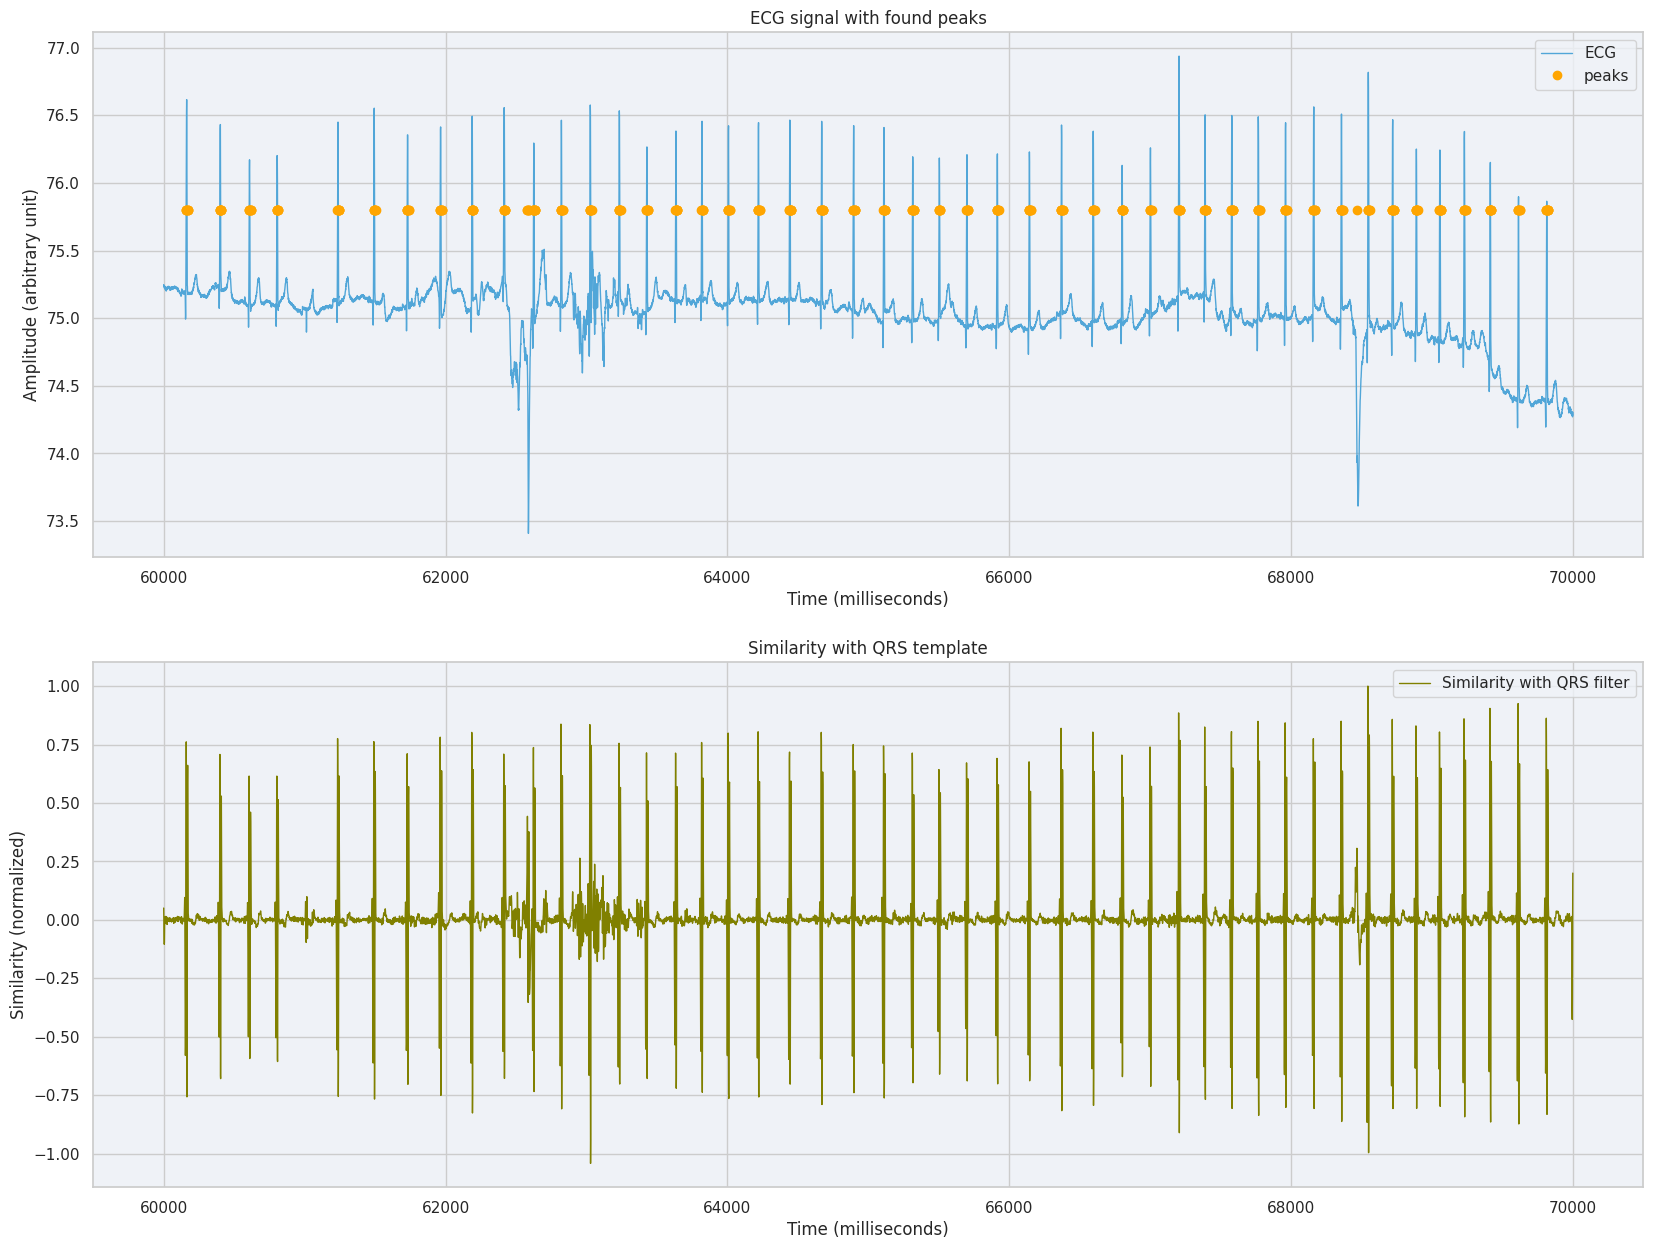

In [177]:
for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    
    # get slice data of ECG data
    cond_slice = (sliced_ecg_df.index >= start) & (sliced_ecg_df.index < stop) 
    ecg_slice = sliced_ecg_df.heartrate[cond_slice]
    
    #ecg_slice = 5*ecg_slice

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(75.8, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")

In [178]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

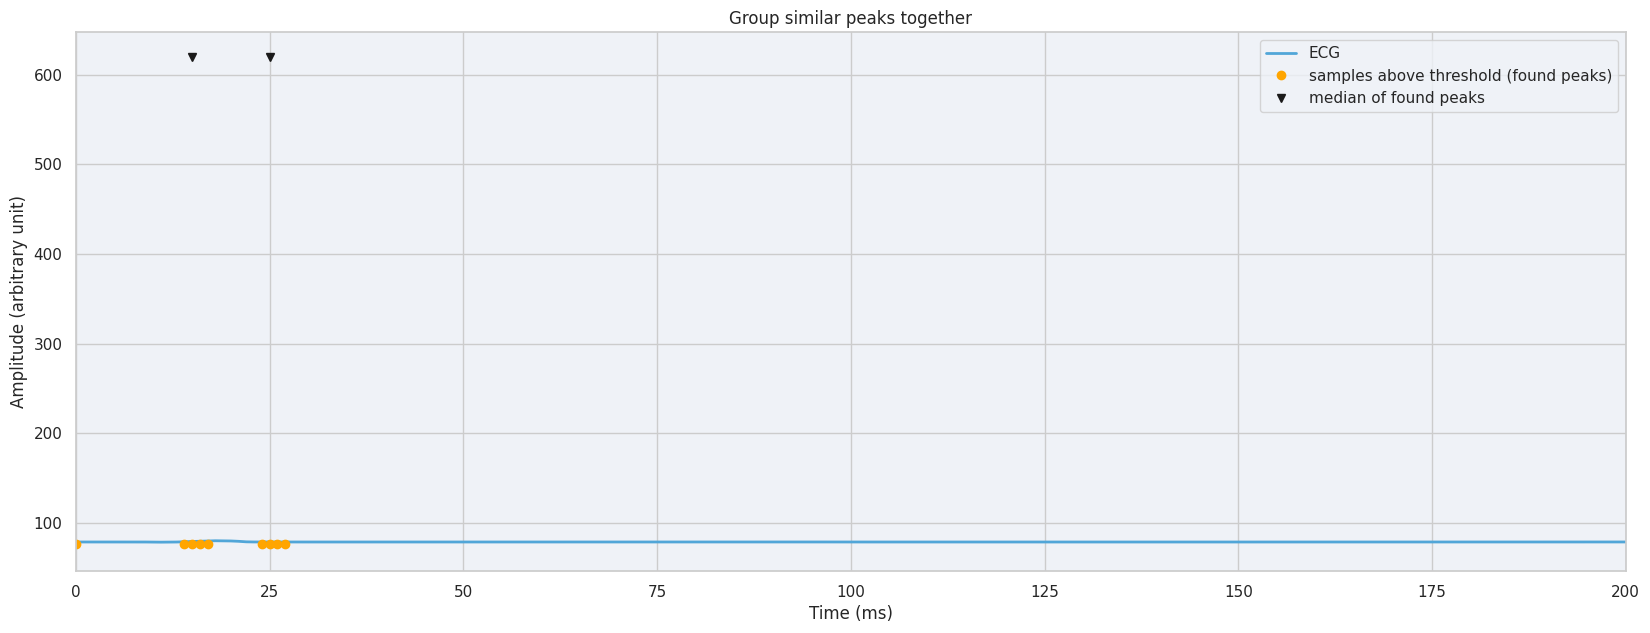

In [180]:
# detect peaks
peaks, similarity = detect_peaks(sliced_ecg_df.heartrate, threshold=0.3)

# group peaks
grouped_peaks = group_peaks(peaks)

# plot peaks
plt.figure(figsize=(20, 7))
plt.title("Group similar peaks together")
plt.plot(sliced_ecg_df.index, sliced_ecg_df.heartrate, label="ECG", color="#51A6D8", linewidth=2)
plt.plot(peaks, np.repeat(75.8, peaks.shape[0]),label="samples above threshold (found peaks)", color="orange", marker="o", linestyle="None")
plt.plot(grouped_peaks, np.repeat(620, grouped_peaks.shape[0]), label="median of found peaks", color="k", marker="v", linestyle="None")
plt.legend(loc="upper right")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude (arbitrary unit)")
plt.gca().set_xlim(0, 200)
plt.show()